# Regresor y clasificador de aumento de gradiente con hiperparámetros ajustados + Algo de ingeniería de características

Este cuaderno lo preparé con dos algoritmos ml: GradientBoostingRegressor y GradientBoostingClassifier de sklearn, porque en mi experimento realizaron una puntuación más grande con datos de prueba e hiperparámetros estándar.
También entrenan mucho más rápido que las redes neuronales.

# Importación de bibliotecas y lectura de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Explorando datos

Veamos los datos y unamos las piezas de entrenamiento y prueba para que sea muy conveniente trabajar con ellas.

In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
full_df = pd.concat([train_df, test_df]).reset_index(
    drop=True).drop(['PassengerId'], axis=1)

Ok, ahora tengo un marco de datos completo, echemos un vistazo.
Por lo tanto, faltan algunos valores en las características Edad, Tarifa, Cabina y Embarque

In [6]:
full_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


# Valores faltantes

Crear otro marco de datos con estas características me brinda la oportunidad de trabajar con datos sin accidentes en el marco de datos principal

In [8]:
miss_data = full_df[['Age', 'Fare', 'Cabin', 'Embarked']]

In [9]:
miss_data.value_counts()

Age    Fare      Cabin    Embarked
36.00  120.0000  B96 B98  S           2
25.00  55.4417   E50      C           2
50.00  211.5000  C80      C           2
24.00  69.3000   B35      C           2
0.92   151.5500  C22 C26  S           1
                                     ..
30.00  151.5500  C22 C26  S           1
       164.8667  C7       S           1
31.00  28.5375   C53      C           1
       50.4958   A24      S           1
80.00  30.0000   A23      S           1
Length: 266, dtype: int64

In [10]:
# Echa un vistazo a las características numéricas
miss_data.describe()

,Age,Fare
count,1046.000000,1308.000000
mean,29.881138,33.295479
std,14.413493,51.758668
min,0.170000,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,39.000000,31.275000
max,80.000000,512.329200


In [11]:
print(f'''
    Conteo de edades faltantes: {miss_data.Age.isna().sum()} or {round(miss_data.Age.isna().sum() * 100 / len(miss_data), 2)} %
    Recuento de tarifas faltantes: {miss_data.Fare.isna().sum()} or {round(miss_data.Fare.isna().sum() * 100 / len(miss_data), 2)}
    Recuento de cabañas desaparecidas: {miss_data.Cabin.isna().sum()} or {round(miss_data.Cabin.isna().sum() * 100 / len(miss_data), 2)} %
    Recuento de desaparecidos embarcados: {miss_data.Embarked.isna().sum()} or {round(miss_data.Embarked.isna().sum() * 100 / len(miss_data), 2)} %
    ''')


    Conteo de edades faltantes: 263 or 20.09 %
    Recuento de tarifas faltantes: 1 or 0.08
    Recuento de cabañas desaparecidas: 1014 or 77.46 %
    Recuento de desaparecidos embarcados: 2 or 0.15 %
    


Parece posible hacer algo de trabajo con la función AGE porque hay relativamente pocos valores faltantes, puedo restaurarlos con el promedio o con el valor más común, pero intentaré verificar cómo esta función se correlaciona con otras funciones, tal vez sea posible para hacer la agrupación por otras características y llenar nans con el valor del grupo más común

Tarifa: hay un valor de nan, la solución es reemplazar el nan con el valor más utilizado. También hay valores cero y eso es interesante. Tal vez la tripulación tenía una tarifa cero, pero aun así quiero estar seguro de que esta suposición es correcta.
 
Embarcado: el número de NaN es tan pequeño que los reemplazaré por el valor más frecuente.

Cabina - categórica, alfanumérica, con 77 por ciento de NaN.
No es posible restaurar correctamente todos los NaN en esta función con datos de este conjunto de datos, la decisión es eliminar esta función.

In [12]:
full_df[full_df.Fare == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [13]:
full_df[full_df.Fare == 0].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,15.000000,17.000000,8.000000,17.0,17.0,17.0
mean,0.066667,1.823529,36.875000,0.0,0.0,0.0
std,0.258199,0.808957,10.494046,0.0,0.0,0.0
min,0.000000,1.000000,19.000000,0.0,0.0,0.0
25%,0.000000,1.000000,33.250000,0.0,0.0,0.0
50%,0.000000,2.000000,38.500000,0.0,0.0,0.0
75%,0.000000,2.000000,42.250000,0.0,0.0,0.0
max,1.000000,3.000000,49.000000,0.0,0.0,0.0


Ok, está claro que todos los pasajeros con tarifa cero eran hombres.
Todos ellos eran del mismo puerto y estaban sin Familia.
Creo que todos ellos eran realmente parte de la tripulación.
Entonces me parece una mala idea reemplazar estos valores.

In [14]:
full_df.Embarked.fillna(full_df.Embarked.mode()[0], inplace = True)
full_df.Fare.fillna(full_df.Fare.mode()[0], inplace = True)
full_df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

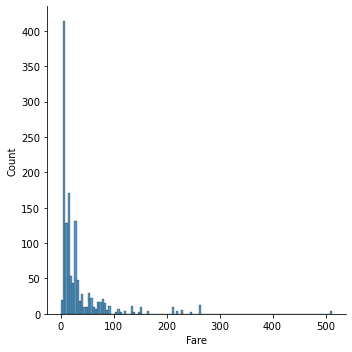

In [15]:
sns.displot(data=full_df, x='Fare')

Después de una mirada rápida a la función de tarifa, se me ocurrió la idea de crear una nueva función con clases de tarifa.
Podría ser mucho más sencillo agrupar con nuevas funciones.
También voy a comprobar si la nueva función aumenta la correlación.

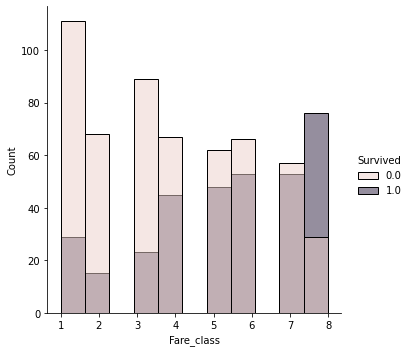

In [16]:
Fare_class = pd.qcut(full_df.Fare, q=8, labels=[1, 2, 3, 4, 5, 6, 7, 8])
full_df['Fare_class'] = Fare_class.astype(int)
# Let's take a look how Fare_class effects on Survival. I see almost linear dependence from 2 to 8 classes
sns.displot(data=full_df, x='Fare_class', hue='Survived')

In [17]:
full_df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_class
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.322280
Pclass,-0.338481,1.000000,-0.408106,0.060832,0.018322,-0.558740,-0.723707
Age,-0.077221,-0.408106,1.000000,-0.243699,-0.150917,0.177286,0.179247
SibSp,-0.035322,0.060832,-0.243699,1.000000,0.373587,0.160388,0.343066
Parch,0.081629,0.018322,-0.150917,0.373587,1.000000,0.221668,0.341250
Fare,0.257307,-0.558740,0.177286,0.160388,0.221668,1.000000,0.620702
Fare_class,0.322280,-0.723707,0.179247,0.343066,0.341250,0.620702,1.000000


El corte por clase me ha llevado a la idea de trabajar en el corte por nombre, porque en el conjunto de datos cada nombre tiene algún tipo de atractivo como señorita, señor, etc.

In [18]:
full_df['Title']=0
full_df['Title']=full_df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
full_df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [19]:
full_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_class,Title
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1,Mr
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,8,Mrs
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,3,Miss
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,7,Mrs
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,3,Mr
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,S,3,Mr
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C,8,Dona
1306,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S,1,Mr
1307,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,S,3,Mr


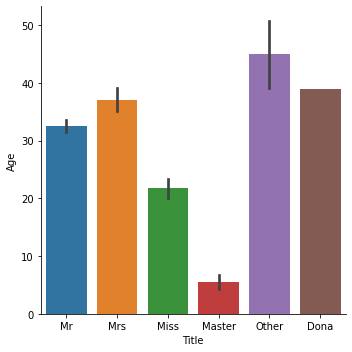

In [20]:
#let's check how successful this idea is
sns.catplot(data=full_df, y='Age', x='Title', kind='bar')

In [21]:
full_df.isna().sum()

Survived      418
Pclass          0
Name            0
Sex             0
Age           263
SibSp           0
Parch           0
Fare            0
Embarked        0
Fare_class      0
Title           0
dtype: int64

In [22]:
full_df.drop(['Age'], axis=1).corrwith(other=full_df.Age)

Survived     -0.077221
Pclass       -0.408106
SibSp        -0.243699
Parch        -0.150917
Fare          0.177286
Fare_class    0.179247
dtype: float64

In [23]:
full_df.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

Para mí está completamente claro que la edad tiene una correlación negativa con Pclass, es decir, en promedio, los pasajeros de primera clase son mayores que los pasajeros de tercera clase. Sobre la misma base, puedo afirmar que cuantos más miembros de la familia, menor es la edad.
Cuanto mayor sea el precio del billete, mayor será la edad.
También la edad depende del título muy fuerte.

Es obvio que existe una ligera dependencia de la edad con respecto a la supervivencia, por lo que no quiero reemplazar el valor con la moda o el valor promedio.
Quiero llenar NaNs en esta función correctamente.
Por otro lado, no exploré la correlación con categóricos como: Sex y Embarked, por lo que deben codificarse.
Después de esta manipulación, puedo tomar una decisión sobre cómo debo llenar NaNs en la función de edad.

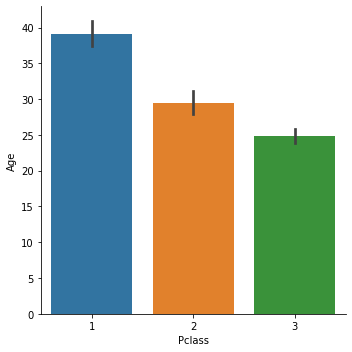

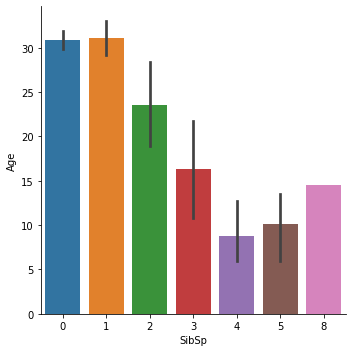

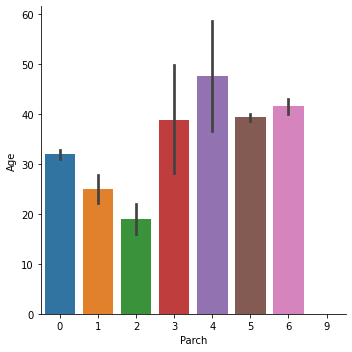

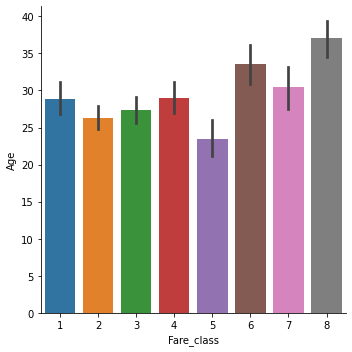

In [24]:
#Visualization of these statements
sns.catplot(data=full_df, y='Age', x='Pclass', kind='bar')
sns.catplot(data=full_df, y='Age', x='SibSp', kind='bar')
sns.catplot(data=full_df, y='Age', x='Parch', kind='bar')
sns.catplot(data=full_df, y='Age', x='Fare_class', kind='bar')


In [25]:
le = LabelEncoder()
categorical_features = ['Sex', 'Title', 'Embarked']
full_df_enc = full_df.copy()
for feature  in categorical_features: 
    feature_enc = le.fit_transform(full_df[feature])
    full_df_enc[feature] = pd.Series(feature_enc.reshape(-1,))
# full_df_enc = pd.concat([full_df.drop(['Sex', 'Embarked', 'Title'], axis=1), enc], axis=1).reset_index(drop=True)
# full_df_enc


In [26]:
full_df_enc

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_class,Title
0,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2,1,3
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0,8,4
2,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2,3,2
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2,7,4
4,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",1,NaN,0,0,8.0500,2,3,3
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,108.9000,0,8,0
1306,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,7.2500,2,1,3
1307,NaN,3,"Ware, Mr. Frederick",1,NaN,0,0,8.0500,2,3,3


<AxesSubplot:>

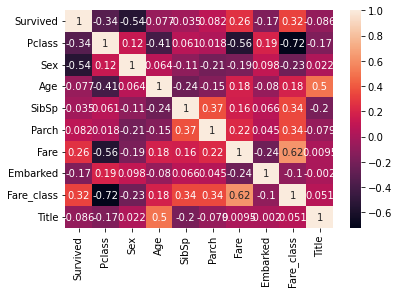

In [27]:
sns.heatmap(data=full_df_enc.corr(), annot=True)

Ahora tengo 8 características que se correlacionan con la edad y me parece que no está disponible para agrupar pasajeros por todas estas características, no es posible, pero ¿qué pasa si algunos grupos solo tienen valores de NaN demasiado pequeños y contienen expulsiones?
Tal vez podría elegir algunas de las funciones para agrupar, pero creo que el algoritmo ML podría llenar NaN más fácilmente e incluso mejor que yo manualmente.

In [28]:
full_df_enc.Title.value_counts()

3    770
2    265
4    199
1     61
5     13
0      1
Name: Title, dtype: int64

Un pasajero con Título == 0, esto no es adecuado para dividirlo en prueba y entrenamiento, porque quiero estratificar exactamente por Título, porque la edad se correlaciona más fuertemente con este rasgo.
La solución es asignar a este pasajero el Título similar más cercano

In [29]:
full_df_enc.loc[full_df_enc['Title'] == 0, 'Title'] = 4

In [30]:
full_df_enc.drop(['Age'], axis=1).corrwith(other=full_df_enc.Age)

Survived     -0.077221
Pclass       -0.408106
Sex           0.063645
SibSp        -0.243699
Parch        -0.150917
Fare          0.177286
Embarked     -0.080195
Fare_class    0.179247
Title         0.505016
dtype: float64

In [31]:
X = full_df_enc[full_df_enc['Age'].notna()].drop(['Age', 'Name', 'Survived'], axis=1)
y = full_df_enc[full_df_enc['Age'].notna()].Age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=X['Title'])

i've tried to train model without scaling and result was the same.
Also i have tried different sizes of split.
Hyperparameters was tuned by RandomSearch CV and GridSerachCV and after all manually. 
There was an attempt with better score but it accidental was lost, 
after several attemts to repeat this score i have stoped trying.
Performed model is not optimal, but still not bad, and its still better than filling NaNs with mean, mode or with grouping functions.

In [32]:
# regr_1 = DecisionTreeRegressor(random_state=0)
# regr_2 = RandomForestRegressor(random_state=0)
regr_3 = GradientBoostingRegressor(random_state=0, max_depth=4, n_estimators=1200, 
                                   learning_rate=0.018, loss='huber', warm_start=True, verbose=1)
# regr_4 = AdaBoostRegressor(random_state=0)
# regr_5 = LinearRegression()
# regr_6 = LassoCV(random_state=0)
# regr_7 = Ridge(random_state=0)
# regr_8 = BayesianRidge()
# regr_9 = TweedieRegressor()
# regr_10 = PassiveAggressiveRegressor()
# regr_11 = KNeighborsRegressor(n_neighbors=5, weights='distance')
# regr_12 = MLPRegressor(max_iter= 1000, warm_start=True, activation='logistic',
#                        random_state=0, verbose=1, n_iter_no_change=5)
regressors = [regr_3]
for regressor in regressors:
    pipe = Pipeline([('scaler', StandardScaler()), ('regr', regressor)])
    pipe.fit(X_train, y_train)
#     Pipeline(steps=[('scaler', StandardScaler()), ('regr', regressor)])
    print(regressor)
    print(pipe.score(X_train, y_train))
    print(f' test_score: {pipe.score(X_test, y_test)}')
    


      Iter       Train Loss   Remaining Time 
         1         102.8716           10.70s
         2         100.9939            9.48s
         3          99.1788           10.15s
         4          97.4216            9.89s
         5          95.7196            9.56s
         6          94.0732            9.18s
         7          92.4790            9.46s
         8          90.9349            9.22s
         9          89.4405            9.30s
        10          88.0954            9.09s
        20          76.4631            8.00s
        30          67.7350            7.39s
        40          61.8180            7.33s
        50          58.0178            6.98s
        60          55.2027            6.73s
        70          53.2457            6.73s
        80          51.7856            6.76s
        90          50.5997            6.83s
       100          49.8065            6.76s
       200          43.7665            7.92s
       300          40.2002            7.49s
       40

In [33]:
pd.Series(pipe.predict(X_test)-y_test).describe()

count    105.000000
mean       1.116978
std        8.181684
min      -19.750954
25%       -4.098607
50%        0.852223
75%        6.851564
max       26.049664
Name: Age, dtype: float64

In [34]:
full_df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Name        1309 non-null   object 
 3   Sex         1309 non-null   int32  
 4   Age         1046 non-null   float64
 5   SibSp       1309 non-null   int64  
 6   Parch       1309 non-null   int64  
 7   Fare        1309 non-null   float64
 8   Embarked    1309 non-null   int32  
 9   Fare_class  1309 non-null   int32  
 10  Title       1309 non-null   int32  
dtypes: float64(3), int32(4), int64(3), object(1)
memory usage: 92.2+ KB


In [35]:
predicted_age = pipe.predict(full_df_enc[full_df_enc['Age'].isna()].drop(['Name', 'Survived', 'Age'], axis=1))

In [36]:
full_df_enc.loc[full_df_enc['Age'].isna(), 'Age'] = np.round(predicted_age, 1)

<AxesSubplot:>

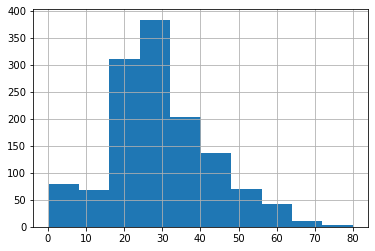

In [37]:
full_df_enc.Age.hist()

<AxesSubplot:>

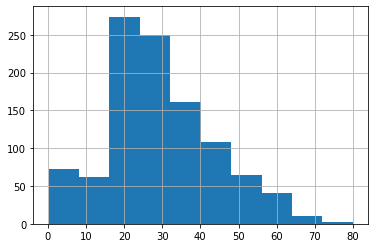

In [38]:
full_df.Age.hist()

Veo que el algoritmo no afectó mucho la distribución, creo que el resultado es aceptable.

# Modelo de predicción

In [39]:
X_sur = full_df_enc.loc[full_df_enc.Survived.notna()].drop(['Survived', 'Name'], axis=1)  
y_sur = np.array(full_df_enc.loc[full_df_enc.Survived.notna()]['Survived'].astype(int))
X_train_sur, X_test_sur, y_train_sur, y_test_sur = train_test_split(X_sur, y_sur, test_size=0.4, random_state = 0, stratify=X_sur['Title'])

In [40]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest, RandomForestClassifier, RandomTreesEmbedding, StackingClassifier
from sklearn.ensemble import VotingClassifier
# from hpbandster_sklearn import HpBandSterSearchCV

In [41]:
# clf = GradientBoostingClassifier(random_state=0)
# param_distributions = {'loss': ['deviance', 'exponential'],
#                        'learning_rate': [float(_) for _ in np.linspace(0.0001, 1, 50)],
#                        'n_estimators': [int(_) for _ in np.linspace(200, 5000, 20)],
#                        'subsample': [float(_) for _ in np.linspace(0.5, 1, 20)],
#                        'criterion': ['friedman_mse', 'mse'],
#                        'min_samples_split': [int(_) for _ in np.linspace(2, 20, 18)],
#                        'min_samples_leaf': [int(_) for _ in np.linspace(1, 15, 14)],
#                        'max_depth': [int(_) for _ in np.linspace(2, 10, 8)],
#                        'max_leaf_nodes': [int(_) for _ in np.linspace(2, 10, 8)],
#                        }

# search = HpBandSterSearchCV(
#     clf, param_distributions, random_state=0, n_jobs=1, n_iter=500, verbose=1).fit(X_train_sur, y_train_sur)
# search.best_params_

In [42]:
# classifier_1 = DummyClassifier()
# classifier_2 = LogisticRegression()
# classifier_3 = LogisticRegressionCV()
# classifier_4 = PassiveAggressiveClassifier()
# classifier_5 = GaussianProcessClassifier()
# classifier_6 = AdaBoostClassifier()
# classifier_7 = BaggingClassifier()
# classifier_8 = ExtraTreesClassifier()
# classifier_9 = GradientBoostingClassifier(random_state=0, max_depth=2, n_estimators=3000,
#                                           learning_rate=0.005, warm_start=False)
classifier_10 = GradientBoostingClassifier(random_state=0, 
                                           criterion='friedman_mse',
                                           learning_rate=0.18,
                                           loss='exponential',
                                           max_depth=5,
                                           max_leaf_nodes=30,
                                           min_samples_leaf=3,
                                           min_samples_split=20,
                                           subsample=0.9736842105263157,
                                           n_estimators=22)
# classifier_11 = RandomForestClassifier(n_estimators=550, criterion='entropy', max_depth=5, min_samples_split=3, min_impurity_decrease=0.01)
# classifier_12 = StackingClassifier(estimators=)
# classifier_13 = VotingClassifier()

In [43]:
classifiers = [classifier_10]
for classifier in classifiers:
    classifier.fit(X_train_sur, y_train_sur)
    print(classifier)
    print(f'train score: {classifier.score(X_train_sur, y_train_sur)}')
    print(f'test score: {classifier.score(X_test_sur, y_test_sur)}')

GradientBoostingClassifier(learning_rate=0.18, loss='exponential', max_depth=5,
                           max_leaf_nodes=30, min_samples_leaf=3,
                           min_samples_split=20, n_estimators=22,
                           random_state=0, subsample=0.9736842105263157)
train score: 0.9044943820224719
test score: 0.8739495798319328


In [44]:
confusion_matrix(y_test_sur, classifier_10.predict(X_test_sur))

array([[221,  17],
       [ 28,  91]], dtype=int64)

In [45]:
predicted_survived = classifier_10.predict(full_df_enc.loc[full_df_enc.Survived.isna()].drop(['Name', 'Survived'], axis=1))

In [46]:
predicted_survived

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [47]:
test_df['Survived'] = predicted_survived.astype(int)

# Envío

In [48]:
submission = pd.DataFrame(index=[test_df.PassengerId, test_df.Survived])

In [49]:
submission.to_csv('submission.csv')